# Computer simulations course 2018/2019-2 @ ELTE
# Assignment 3: Planetary Motions - Threebody problem
## 03.03.2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import sys
from scipy import stats
import time
import imageio
import os, shutil
from matplotlib.patches import Circle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
sns.set_style(style='whitegrid')

### Planets

In [3]:
# [Mass in kg,
#  Distance from central celestail body in AU,
#  eccentricity,
#  Size in AU]
Planets={
    'Sun': [1.989e30, 0, 0.0001, 4.649e-03],
    'Moon': [7.348e22, 0.00257, 0.0549, 1.161e-05],
    'Mercury': [3.285e23, 0.466697, 0.205630, 1.631e-05],
    'Venus': [4.867e24, 0.728213, 0.006772, 4.045e-05],
    'Earth': [5.972e24, 1.017, 0.0167086, 4.259e-05],
    'Mars': [6.39e23, 1.666, 0.0934, 2.266e-05],
    'Jupiter': [1.898e27, 5.4588, 0.0489, 4.673e-04],
    'Saturn': [5.683e26, 10.1238, 0.0565, 3.893e-04],
    'Uranus': [8.681e25, 20.11, 0.046381, 1.695e-04],
    'Neptune': [1.024e26, 30.33, 0.009456, 1.646e-04],
    'Pluto': [1.309e22, 49.305, 0.2488, 7.954e-06],
    'Halley': [2.2e14, 35.082, 0.96714, 3.68e-08]
}

Planet_Colors={
    'Sun': np.array([216, 148, 29])/255,
    'Moon': np.array([204, 198, 195])/255,
    'Mercury': np.array([186, 186, 186])/255,
    'Venus': np.array([216, 194, 153])/255,
    'Earth': np.array([45, 52, 130])/255,
    'Mars': np.array([217, 120, 62])/255,
    'Jupiter': np.array([187, 155, 99])/255,
    'Saturn': np.array([222, 181, 82])/255,
    'Uranus': np.array([201, 239, 241])/255,
    'Neptune': np.array([72, 120, 242])/255,
    'Pluto': np.array([65, 25, 20])/255,
    'Halley': np.array([0,0,0])/255
}

## Initial conditions

In [181]:
choosen_planet_1 = 'Sun'
choosen_planet_2 = 'Jupiter'

# Gravitational constant [AU^3 * kg^-1 * year^-2]
G = 1.9838e-29

# Masses of choosen bodies [kg]
if(choosen_planet_1 != ''):
    m_1 = Planets[choosen_planet_1][0]
else:
    m_1 = Planets['Saturn'][0]

if(choosen_planet_2 != ''):
    m_2 = Planets[choosen_planet_2][0]
else:
    m_2 = Planets['Jupiter'][0]

# Eccentricity of choosen bodies
if(choosen_planet_1 != ''):
    ecc_1 = Planets[choosen_planet_1][2]
else:
    ecc_1 = 0.6
if(choosen_planet_2 != ''):
    ecc_2 = Planets[choosen_planet_2][2]
else:
    ecc_2 = 0.8

# Distance of the choosen bodies' center of mass [AU]
if(choosen_planet_2 != ''):
    r_dist = Planets[choosen_planet_2][1]
else:
    r_dist = 0.1

# Step size
dt = 1e-2
# Adaptive accuracy of simulation
accuracy = 1e-12

# Calculated orbit parameters
# r_ap: Apogee distance; measured from the system's center of mass
# a: semi-major axis in [AU]
# b: semi-minor axis in [AU]
r_ap_1 = m_2/(m_1+m_2) * r_dist
r_ap_2 = m_1/(m_1+m_2) * r_dist
a_1 = r_ap_1 / (1 + ecc_1)
a_2 = r_ap_2 / (1 + ecc_2)
b_1 = np.sqrt(1 - ecc_1**2) * a_1
b_2 = np.sqrt(1 - ecc_2**2) * a_2

# Velocities in the apogee [AU/year]
v0_1 = np.sqrt(G * m_2**3/(m_1 + m_2)**2 * (2 / r_ap_1 - 1 / a_1))  # Initial velocity of first body (tangential along y-axis) [AU/day]
v0_2 = np.sqrt(G * m_1**3/(m_1 + m_2)**2 * (2 / r_ap_2 - 1 / a_2))  # Initial velocity of second body (tangential along y-axis) [AU/day]

# Orbital period in [year]
T = np.sqrt(4 * np.pi * np.pi * np.power(r_dist,3)/ (G * (m_1 + m_2)))

# Number of years to plot
plotting_years = 5 * T

# Others
steps = 1
fps = 40
image_dpi = 150
image_format = 'pdf'
image_path = '..\\Documentation\\src\\images\\three_body\\'

In [182]:
print('r_ap_1:', r_ap_1)
print('r_ap_2:', r_ap_2)

print('a_1:', a_1)
print('a_2:', a_2)

print('T:', T)

print('v0_1:', v0_1)
print('v0_2:', v0_2)

r_ap_1: 0.0052040849907931
r_ap_2: 5.453595915009207
a_1: 0.005203564634329667
a_2: 5.199347807235396
T: 12.751233381171915
v0_1: 0.0025641908058361956
v0_2: 2.6207386905164456


## Generating small bodies

In [183]:
def sign_choose():
    return -1 if random.random() < 0.5 else 1

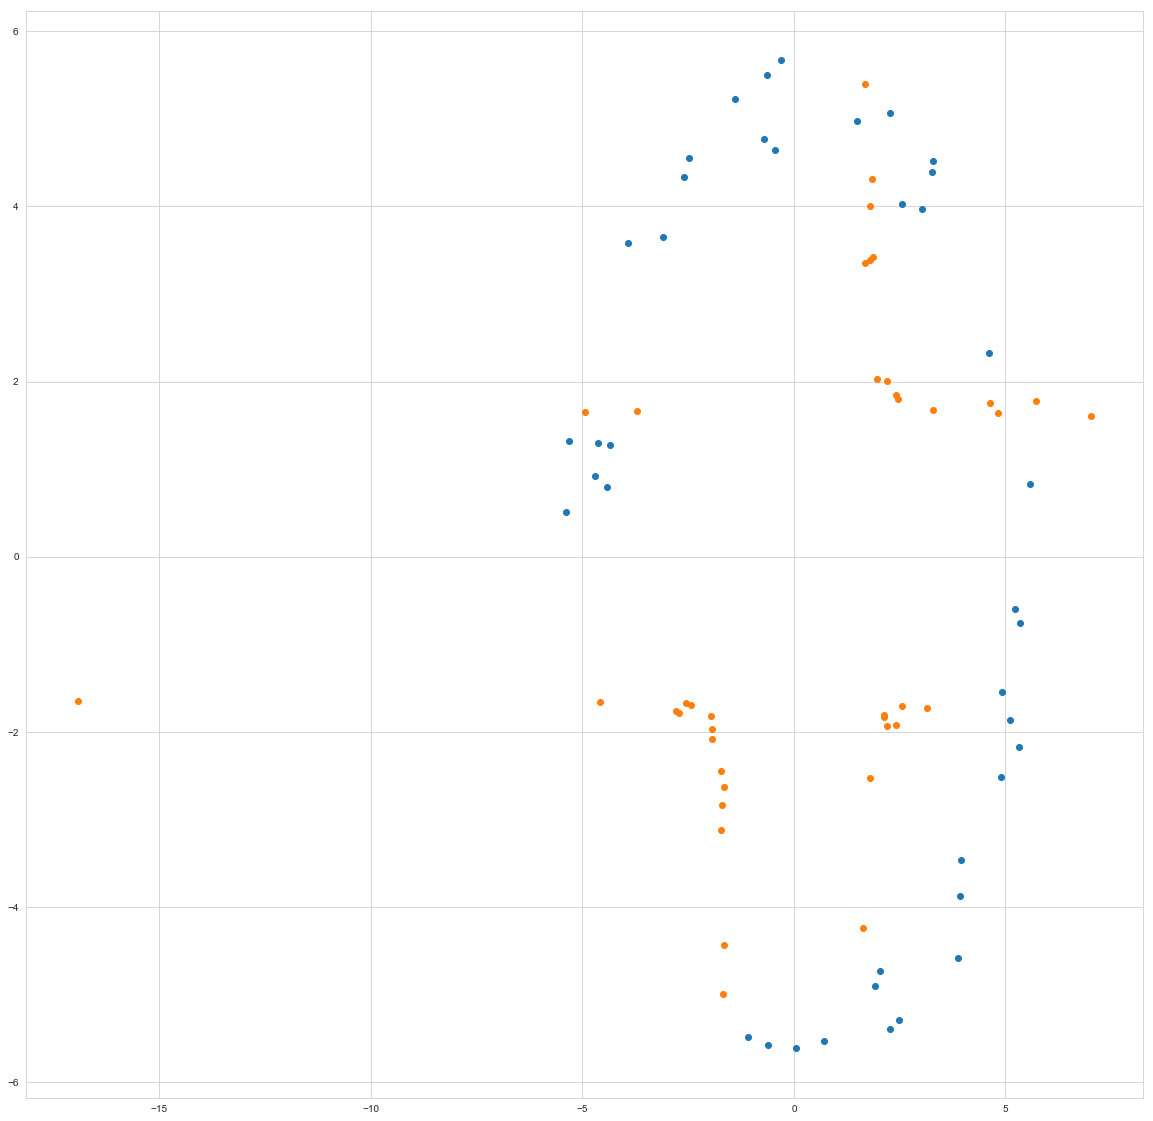

In [184]:
half_number_of_bodies = 20

coordinates_array = np.zeros((2*half_number_of_bodies, 5))

nrows = 1
ncols = 1
picsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*(picsize)*(a_2/b_2),nrows*picsize))

x_scatter = 0.1
y_scatter = 0.1
for i in range(0, half_number_of_bodies):
    
    # X coordinates
    coordinates_array[i,1] = random.random() * a_2 * sign_choose()
    # Y coordinates
    coordinates_array[i,2] = b_2/a_2 * np.sqrt(a_2**2 - coordinates_array[i,1]**2) * sign_choose()
    
for i in range(half_number_of_bodies, 2*half_number_of_bodies):
    
    # Y coordinates
    coordinates_array[i,2] = random.random() * b_2 * sign_choose()
    # X coordinates
    coordinates_array[i,1] = a_2/b_2 * np.sqrt(b_2**2 - coordinates_array[i,2]**2) * sign_choose()
    
# Scatter particles
norm = 2.3
for i in range(0, 2*half_number_of_bodies):
    
    coordinates_array[i,0] = random.random() * 1e15
    coordinates_array[i,1] += random.random() * x_scatter * a_2 * sign_choose() - (a_2 - (1+ecc_2) * a_2)
    coordinates_array[i,2] += random.random() * y_scatter * b_2 * sign_choose()
    
    # X velocities
    if(coordinates_array[i,2] < 0):
        coordinates_array[i,3] = -np.sqrt(np.abs(4 * np.pi * np.pi * (2/coordinates_array[i,1]) - 1/a_2))/norm
    else:
        coordinates_array[i,3] = np.sqrt(np.abs(4 * np.pi * np.pi * (2/coordinates_array[i,1]) - 1/a_2))/norm
    
    # Y velocities
    if(coordinates_array[i,1] < 0):
        coordinates_array[i,4] = np.sqrt(np.abs(4 * np.pi * np.pi * (2/coordinates_array[i,2]) - 1/a_2))/norm
    else:
        coordinates_array[i,4] = -np.sqrt(np.abs(4 * np.pi * np.pi * (2/coordinates_array[i,2]) - 1/a_2))/norm

# Save to dat file
np.savetxt('small_objects.dat', coordinates_array, delimiter='\t')
    
axes.scatter(coordinates_array[::steps,1], coordinates_array[::steps,2])
axes.scatter(coordinates_array[::steps,3], coordinates_array[::steps,4])
plt.show()

## Run simulation

### Command line arguments

In [185]:
def mode_choose(mode, odeint, relat):
    
    current_mode = ('..\Release\kepler_three.exe ' +
                    mode + ' ' +
                    odeint + ' ' +
                    relat + ' ' +
                    str(m_1) + ' ' +
                    str(m_2) + ' ' +
                    str(r_dist) + ' ' +
                    str(ecc_1) + ' ' +
                    str(ecc_2) + ' ' +
                    str(plotting_years) + ' ' +
                    str(dt) + ' ' +
                    str(accuracy) + ' ' +
                    str(half_number_of_bodies * 2)
                   )

    return(current_mode)

In [186]:
current_mode = mode_choose(mode = 'fixed', odeint='runge', relat='no')
os.system(current_mode)

0

In [187]:
data_fixed = np.genfromtxt('fixed.dat')

In [188]:
data_fixed.shape

(6376, 13)

In [189]:
data_small = np.genfromtxt('fixed_smalls.dat')

In [190]:
data_small.shape

(6376, 200)

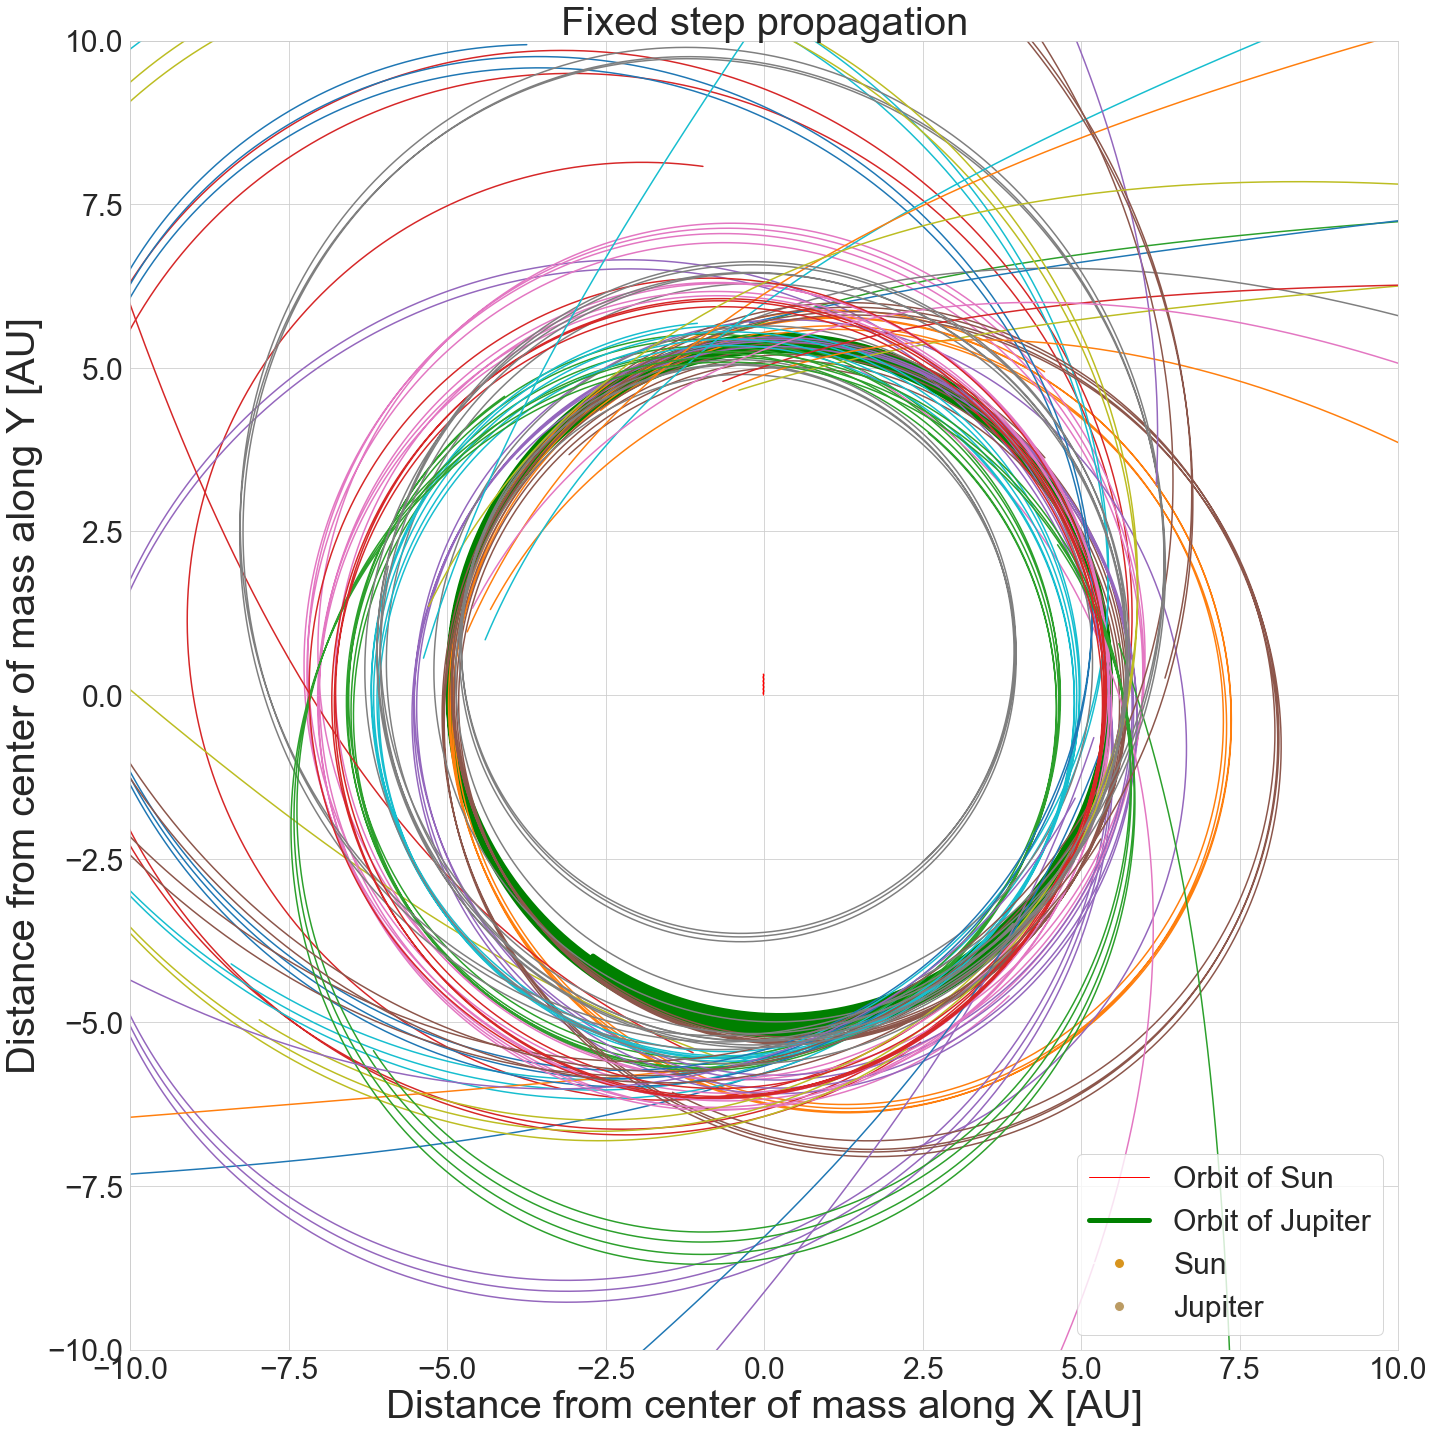

In [191]:
nrows = 1
ncols = 1
picsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*(picsize)*(a_2/b_2),nrows*picsize))

FirstBody = Circle(xy=(r_ap_1, 0), radius=Planets[choosen_planet_1][3], fc=Planet_Colors[choosen_planet_1], zorder=10)
axes.add_patch(FirstBody)

SecondBody = Circle(xy=(r_ap_2, 0), radius=Planets[choosen_planet_2][3], fc=Planet_Colors[choosen_planet_2], zorder=10)
axes.add_patch(SecondBody)

axes.plot(data_fixed[::steps,1], data_fixed[::steps,2], c='red')
axes.plot(data_fixed[::steps,6], data_fixed[::steps,7], c='green', lw=5)

for i in range(0,half_number_of_bodies*2):
    axes.plot(data_small[::steps,1+i*5],data_small[::steps,2+i*5])

axes.set_xlim(-10,10)
axes.set_ylim(-10,10)

axes.set_title('Fixed step propagation', fontsize=40)

axes.set_xlabel('Distance from center of mass along X [AU]', fontsize=40)
axes.set_ylabel('Distance from center of mass along Y [AU]', fontsize=40)

axes.tick_params(axis='both', which='major', labelsize=30)

legend_elements = [Line2D([0], [0], color='red', lw=1, label='Orbit of {0}'.format(choosen_planet_1)),
                   Line2D([0], [0], color='green', lw=5, label='Orbit of {0}'.format(choosen_planet_2)),
                   Line2D([0], [0], marker='o', color='white', markerfacecolor=Planet_Colors[choosen_planet_1],
                          markersize=10, label=choosen_planet_1),
                   Line2D([0], [0], marker='o', color='white', markerfacecolor=Planet_Colors[choosen_planet_2],
                          markersize=10, label=choosen_planet_2)]

axes.legend(handles=legend_elements, fontsize=30)
fig.tight_layout()
plt.savefig(image_path +
            choosen_planet_2 + '_around_' + choosen_planet_1 + '_fixed.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

In [192]:
def ANIMATE_VIDEO(path, video_title):

    video_title = 'threebody.mp4'
    nrows=1
    ncols=1
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*14))

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    width_of_graph = max(r_ap_1, r_ap_2)
    bigger_planet_width = max(Planets[choosen_planet_1][3], Planets[choosen_planet_2][3])
    
    # Coordinates of planets
    x1 = data_fixed[::steps,1]
    y1 = data_fixed[::steps,2]
    x2 = data_fixed[::steps,6]
    y2 = data_fixed[::steps,7]

    # Plot a trail of a planet position for the last trail_secs seconds.
    trail_secs = 5
    # This corresponds to max_trail time points.
    max_trail = int(trail_secs * fps)

    ##ANIMATION STUFF BEGINS HERE##
    # Plot and save an image of the twobody system for time point i
    def animation(i):
            
        # Axis labels
        ax.set_xlabel('Distance from center of mass of S-J [AU]', fontsize=30)
        ax.set_ylabel('Distance from center of mass of S-J [AU]', fontsize=30)

        ax.set_xlim(-width_of_graph - 0.1*width_of_graph, width_of_graph + 0.1*width_of_graph)
        ax.set_ylim(-width_of_graph - 0.1*width_of_graph, width_of_graph + 0.1*width_of_graph)
        ax.set_aspect('equal', adjustable='box')

        # Circles representing the anchor point of rod 1, and bobs 1 and 2.
        planet_1 = Circle((x1[i], y1[i]), Planets[choosen_planet_1][3], fc=Planet_Colors[choosen_planet_1], ec=Planet_Colors[choosen_planet_1], zorder=10)
        planet_2 = Circle((x2[i], y2[i]), Planets[choosen_planet_2][3], fc=Planet_Colors[choosen_planet_2], ec=Planet_Colors[choosen_planet_2], zorder=10)
        ax.add_patch(planet_1)
        ax.add_patch(planet_2)

        # TRAILING EFFECT FROM: https://scipython.com/blog/the-double-pendulum/
        # The trail will be divided into ns segments and plotted as a fading line.
        ns = 20
        s = max_trail // ns

        for j in range(ns):
            imin = i - (ns-j)*s
            if imin < 0:
                imin = 0
            imax = imin + s + 1
            # The fading looks better if we square the fractional length along the trail
            alpha = (j/ns)**2

            ax.plot(x1[imin:imax], y1[imin:imax], c='red', solid_capstyle='butt',
                    lw=2, alpha=alpha)
            ax.plot(x2[imin:imax], y2[imin:imax], c='green', solid_capstyle='butt',
                    lw=2, alpha=alpha)
            
            for i in range(0,half_number_of_bodies*2):
                axes.plot(data_small[::steps,1+i*5][imin:imax],data_small[::steps,2+i*5][imin:imax])

        legend_elements = [Line2D([0], [0], color='red', lw=1, label='Orbit of {0}'.format(choosen_planet_1)),
                           Line2D([0], [0], color='green', lw=1, label='Orbit of {0}'.format(choosen_planet_2)),
                           Line2D([0], [0], marker='o', color='white', markerfacecolor=Planet_Colors[choosen_planet_1],
                                  markersize=10, label=choosen_planet_1),
                           Line2D([0], [0], marker='o', color='white', markerfacecolor=Planet_Colors[choosen_planet_2],
                                  markersize=10, label=choosen_planet_2)]

        ax.legend(handles=legend_elements, loc=1, fontsize=30)

        # Don't show axes, only white background
        #ax.axis('off')
        
        plt.savefig(path + '_img{0:4d}.png'.format(i), dpi=72)    # Save next frame as png
        image = imageio.imread(path + '_img{0:4d}.png'.format(i)) # Load saved image
        writer.append_data(image)                                 # Append this image as the next frame to video

        # Clear the pyplot background for the next frame
        plt.cla()
            
        # Delete the now useless image from frames' folder
        os.unlink(path + '_img{0:4d}.png'.format(i))

    with imageio.get_writer(video_title, fps=fps) as writer:
        for i in range(0, len(x1)):
            sys.stdout.write('\r' + str(i+1) + ' / ' + str(len(x1)))
            sys.stdout.flush()
            animation(i)

In [ ]:
ANIMATE_VIDEO(path = '.\\frames\\', video_title='threebody.mp4')

48 / 6376